In [16]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

import helper_libraries.results_tools as results_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Data

In [17]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

# Return Timing

## Params

In [18]:
## Params
# List of all results folders
results_folders = (
    pd.read_excel("../../results/key.xlsx").query('"Done" in Notes')["Folder"].to_list()
)  ##### <------------------ Finish models!
# Year to start trading
start_year = "2004"

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = ["Benchmark", "LR", "LR_PCA_select", "LR_Lasso_select", "Lasso", "Enet"]

# Latex table params
table_loc = "!h"  # Should be something like htbp
table_fontsize = "footnotesize"
table_output_folder = "../../docs/exhibits/tables"

# Metrics and their names
metrics_list = ["Return", "ReturnAdj", "Sharpe", "SharpeAdj", "Trades", "rvol"]
metrics_names_list = [
    "Return",
    "Adjusted Return",
    "Sharpe",
    "Adjusted Sharpe",
    "Trades",
    "Realized Volatility",
]

## Functions

In [53]:
def plot_returns(oss_returns_all_df, model_list=model_list, figsize=(11, 7)):

    fig, axs = plt.subplots(figsize=figsize, nrows=int(len(model_list) / 2), ncols=2, sharey=True)

    for i, model_select in enumerate(model_list):

        ax = axs.reshape(-1)[i]

        # Get adjusted returns
        oss_returnsadj_all_df = oss_returns_all_df - oss_weights_all_df.diff(1).fillna(
            0
        ).abs().multiply(spread_df.loc[oss_weights_all_df.index, "QSpreadPct_TW_m"] / 2, axis=0)

        # For strategy
        oss_returns_strategy_df = oss_returns_all_df[model_select]
        oss_returnsadj_strategy_df = oss_returnsadj_all_df[model_select]

        # Plot cumulative returns
        sns.lineplot(
            x="datetime",
            y="value",
            hue="variable",
            data=oss_returns_strategy_df[["Market", "Sign", "Positive", "MS Strategy 1"]]
            .rename(columns={"MS Strategy 1": "Std Strategy 1"})
            .groupby(pd.Grouper(freq="1d"))
            .sum()
            .cumsum()
            .melt(ignore_index=False)
            .reset_index(),
            palette="Set2",
            lw=2,
            ax=ax,
        )

        # Highlight recessions
        ax.axvspan(
            pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05
        )
        ax.axvspan(
            pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05
        )

        # Other settings
        ax.set_title(model_select)
        ax.set_xlabel(None)
        ax.set_ylabel("Cumulative Return")
        ax.legend(loc="upper left")

    # Fix legend
    handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=12, loc="lower center", ncol=9, bbox_to_anchor=(0.5, 0))
    for ax in axs.reshape(-1):
        ax.get_legend().remove()

    # Make room for legend
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)

    return fig, axs

In [48]:
def plot_returnsadj(oss_returns_all_df, model_list=model_list, figsize=(11, 7)):

    fig, axs = plt.subplots(figsize=(11, 7), nrows=int(len(model_list) / 2), ncols=2, sharey=True)

    for i, model_select in enumerate(model_list):

        ax = axs.reshape(-1)[i]

        # Get adjusted returns
        oss_returnsadj_all_df = oss_returns_all_df - oss_weights_all_df.diff(1).fillna(
            0
        ).abs().multiply(spread_df.loc[oss_weights_all_df.index, "QSpreadPct_TW_m"] / 2, axis=0)

        # For strategy
        oss_returns_strategy_df = oss_returns_all_df[model_select]
        oss_returnsadj_strategy_df = oss_returnsadj_all_df[model_select]

        # Plot cumulative returns
        sns.lineplot(
            x="datetime",
            y="value",
            hue="variable",
            data=oss_returnsadj_strategy_df[["Market", "Sign", "Positive", "MS Strategy 1"]]
            .rename(columns={"MS Strategy 1": "Std Strategy 1"})
            .groupby(pd.Grouper(freq="1d"))
            .sum()
            .cumsum()
            .melt(ignore_index=False)
            .reset_index(),
            palette="Set2",
            lw=2,
            ax=ax,
        )

        # Highlight recessions
        ax.axvspan(
            pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05
        )
        ax.axvspan(
            pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05
        )

        # Other settings
        ax.set_title(model_select)
        ax.set_xlabel(None)
        ax.set_ylabel("Cumulative Return")
        ax.legend(loc="upper left")

    # Fix legend
    handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=12, loc="lower center", ncol=9)#, bbox_to_anchor=(0.5, 0))
    for ax in axs.reshape(-1):
        ax.get_legend().remove()

    # Make room for legend
    plt.tight_layout()
    # plt.subplots_adjust(bottom=0.125)

    return fig, axs

## Process each set of results

In [ ]:
for folder_name in tqdm(results_folders):

    ### Prep
    ## Get forecast data
    forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
        folder_name=folder_name,
        debug=True,
    )

    ## Get trading results
    # Filter data
    forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
    forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
    fret_filter_df = fret_df.loc[start_year:].copy()
    hrf_filter_df = hrf_df.loc[start_year:].copy()

    # Trading strategies
    (
        oss_results_all_df,
        oss_returns_all_df,
        oss_weights_all_df,
        oss_retpred_all_df,
    ) = results_tools.get_trading_results(
        forecast_oss_filter_df,
        forecast_ins_filter_df,
        spread_df,
        fret_filter_df["ff__mkt"],
        hrf_filter_df["rf"],
        strategies_list,
        model_list,
        hold_cash=True,
    )
    
    fig, _ = plot_returns(oss_returns_all_df)
    fig.savefig(
        f"../../docs/exhibits/figures/timing_return_{results_folder_name}.pdf"
    )
    plt.close()
    
    fig, _ = plot_returnsadj(oss_returns_all_df)
    fig.savefig(
        f"../../docs/exhibits/figures/timing_returnadj_{results_folder_name}.pdf"
    )
    plt.close()

In [22]:
# ### Prep
# ## Get forecast data
# forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
#     folder_name='main',
#     debug=True,
# )


# ## Get trading results
# # Filter data
# forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
# forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
# fret_filter_df = fret_df.loc[start_year:].copy()
# hrf_filter_df = hrf_df.loc[start_year:].copy()

# # Trading strategies
# (
#     oss_results_all_df,
#     oss_returns_all_df,
#     oss_weights_all_df,
#     oss_retpred_all_df,
# ) = results_tools.get_trading_results(
#     forecast_oss_filter_df,
#     forecast_ins_filter_df,
#     spread_df,
#     fret_filter_df["ff__mkt"],
#     hrf_filter_df["rf"],
#     strategies_list,
#     model_list,
#     hold_cash=True,
# )

## Latex for "Results" document

In [23]:
print(r"\section{Return Timing}")

for folder_name in tqdm(results_folders):

    results_folder_name = folder_name
    filename = f"../../docs/exhibits/figures/return_timing_{results_folder_name}.pdf"
    fig_label = 'return_timing_' + results_folder_name
                

    latex_str = (
r"""
\begin{figure}[""" + table_loc + r"""]
\caption{Cumulative Return -- """ + folder_name.replace("_", " ").title() + r"""}  
\label{fig:""" + fig_label + r"""}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{"""
+ filename
+ r"""} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} We compute and plot cumulative daily returns for each model and strategy pair. }     \\  
\end{tabular}
\end{figure}
"""
    )
    print(latex_str)

    print("\n\\clearpage\n")

\section{Return Timing}


  0%|          | 0/9 [00:00<?, ?it/s]


\begin{figure}[!h]
\caption{Cumulative Return -- Main}  
\label{fig:return_timing_main}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{../../docs/exhibits/figures/return_timing_main.pdf} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} We compute and plot cumulative daily returns for each model and strategy pair. }     \\  
\end{tabular}
\end{figure}


\clearpage


\begin{figure}[!h]
\caption{Cumulative Return -- Main Combined}  
\label{fig:return_timing_main_combined}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{../../docs/exhibits/figures/return_timing_main_combined.pdf} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} We compute and plot cumulative daily returns for each model and strategy pair. }     \\  
\end{tabular}
\end{figure}


\clearpage


\begin{figure}[!h]
\caption{Cumulative Return -- Main Cts}  
\labe

# Main Results

In [49]:
folder_name = 'main'

### Prep
## Get forecast data
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name=folder_name,
    debug=True,
)

## Get trading results
# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=False,
)

# Get adjusted returns
oss_returnsadj_all_df = oss_returns_all_df - oss_weights_all_df.diff(1).fillna(
    0
).abs().multiply(spread_df.loc[oss_weights_all_df.index, "QSpreadPct_TW_m"] / 2, axis=0)

  0%|          | 0/6 [00:00<?, ?it/s]

## Returns

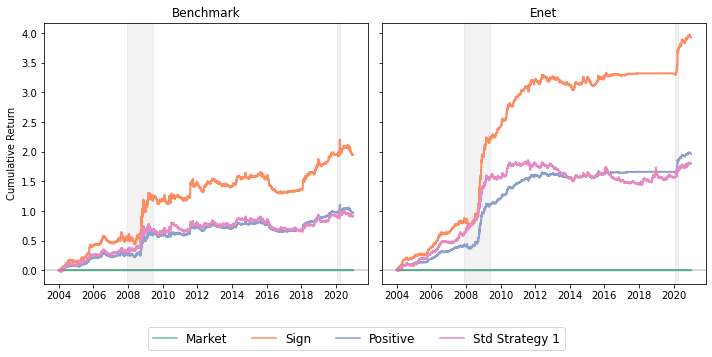

In [56]:
# Regular returns
fig, axs = plot_returns(
    oss_returns_all_df.subtract(oss_returns_all_df["Benchmark"]["Market"].values, axis=0),
    model_list=["Benchmark", "Enet"],
    figsize=(10, 5),
)
[ax.axhline(0, color = 'k', alpha =0.2) for ax in axs]
fig.savefig(
    f"../../docs/exhibits/figures/timing_return_main_diff.pdf"
)

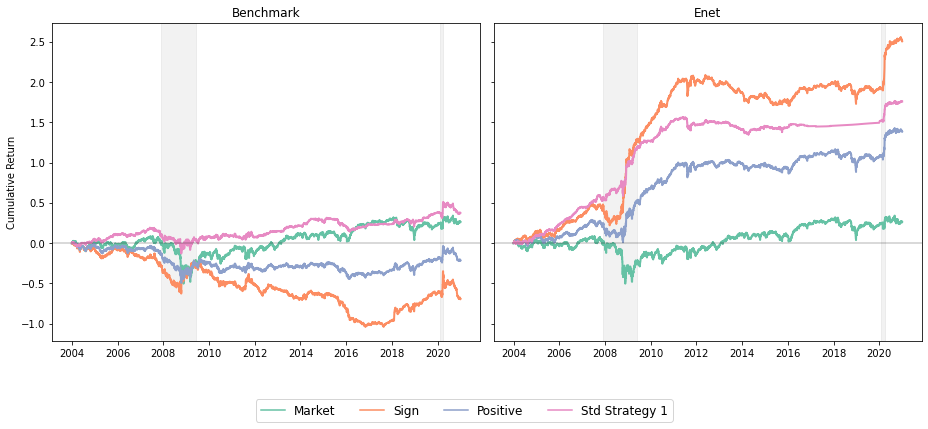

In [77]:
# Adjusted returns - no diff
fig, axs = plot_returns(oss_returnsadj_all_df, model_list=["Benchmark", "Enet"], figsize=(13, 6))
[ax.axhline(0, color="k", alpha=0.2) for ax in axs]
fig.savefig(f"../../docs/exhibits/figures/timing_returnadj_main.pdf")

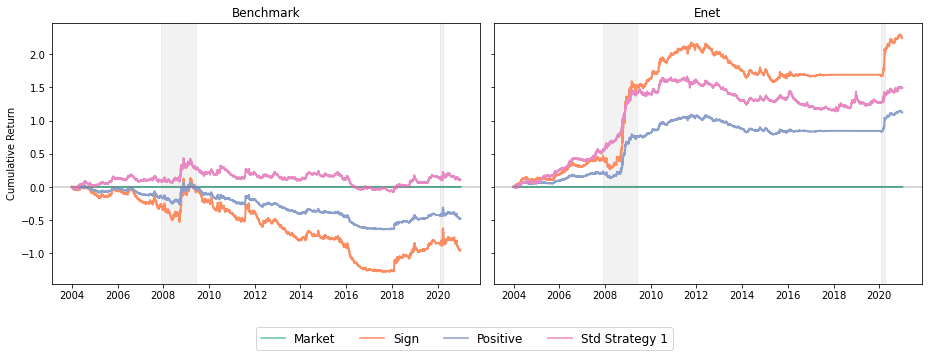

In [70]:
# Adjusted returns
fig, axs = plot_returns(
    oss_returnsadj_all_df.subtract(oss_returns_all_df["Benchmark"]["Market"].values, axis=0),
    model_list=["Benchmark", "Enet"],
    figsize=(13, 5),
)
[ax.axhline(0, color="k", alpha=0.2) for ax in axs]
fig.savefig(f"../../docs/exhibits/figures/timing_returnadj_main_diff.pdf")

## Weights

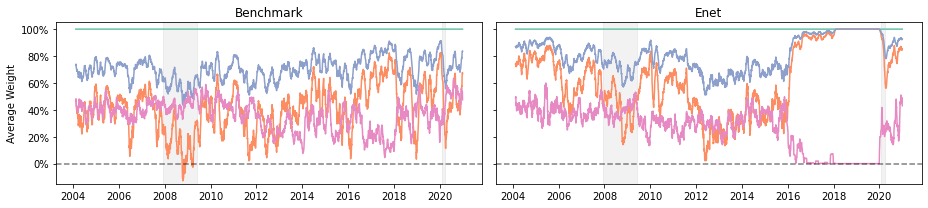

In [71]:
model_list_select = ['Benchmark', 'Enet']
fig, axs = plt.subplots(figsize=(13, 3), nrows=int(len(model_list_select) / 2), ncols=2, sharey=True)

for i, model_select in enumerate(model_list_select):

    ax = axs.reshape(-1)[i]

    # Plot cumulative returns
    sns.lineplot(
        x="datetime",
        y="value",
        hue="variable",
        data=oss_weights_all_df[model_select][["Market", "Sign", "Positive", "MS Strategy 1"]]
        .rename(columns={"MS Strategy 1": "Std Strategy 1"})
        .groupby(pd.Grouper(freq="1d"))
        .mean()
        .dropna()
        .rolling(30)
        .mean()
        .melt(ignore_index=False)
        .reset_index(),
        palette="Set2",
        lw=1.5,
        ax=ax,
    )

    # Highlight recessions
    ax.axvspan(pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05)
    ax.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05)

    # Mark zero weight
    ax.axhline(0, color="k", ls="--", alpha=0.5)

    # Other settings
    ax.set_title(model_select)
    ax.set_xlabel(None)
    ax.set_ylabel("Average Weight")
    ax.legend(loc="upper left")

# Fix legend
handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=12, loc="lower center", ncol=9, bbox_to_anchor=(0.5, 0))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=0))
for ax in axs.reshape(-1):
    ax.get_legend().remove()

# Make room for legend
plt.ylim(-0.15, 1.05)
plt.tight_layout()
# plt.subplots_adjust(bottom=0.125)
fig.savefig(f"../../docs/exhibits/figures/timing_weights_main.pdf")

## Turnover

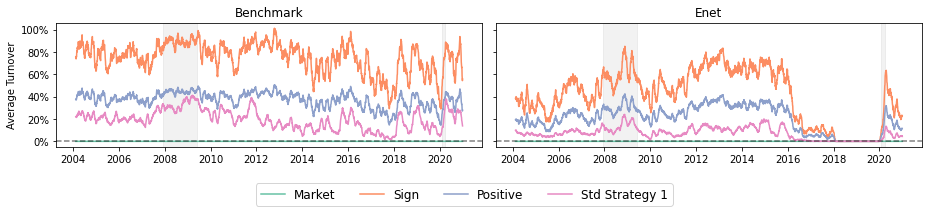

In [76]:
model_list_select = ['Benchmark', 'Enet']
fig, axs = plt.subplots(figsize=(13, 3), nrows=int(len(model_list_select) / 2), ncols=2, sharey=True)

for i, model_select in enumerate(model_list_select):

    ax = axs.reshape(-1)[i]

    # Plot cumulative returns
    sns.lineplot(
        x="datetime",
        y="value",
        hue="variable",
        data=oss_weights_all_df.diff(1)
        .fillna(0)
        .abs()[model_select][["Market", "Sign", "Positive", "MS Strategy 1"]]
        .rename(columns={"MS Strategy 1": "Std Strategy 1"})
        .groupby(pd.Grouper(freq="1d"))
        .mean()
        .dropna()
        .rolling(30)
        .mean()
        # .pipe(lambda x: x * 252)
        .melt(ignore_index=False)
        .reset_index(),
        palette="Set2",
        lw=1.5,
        ax=ax,
    )

    # Highlight recessions
    ax.axvspan(pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05)
    ax.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05)

    # Mark zero weight
    ax.axhline(0, color="k", ls="--", alpha=0.5)

    # Other settings
    ax.set_title(model_select)
    ax.set_xlabel(None)
    ax.set_ylabel("Average Turnover")
    ax.legend(loc="upper left")

# Fix legend
handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=12, loc="lower center", ncol=9, bbox_to_anchor=(0.5, 0))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=0))
for ax in axs.reshape(-1):
    ax.get_legend().remove()

# Make room for legend
# plt.ylim(-0.15, 1.05)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
fig.savefig(f"../../docs/exhibits/figures/timing_turnover_main.pdf")

## Predictions

0it [00:00, ?it/s]

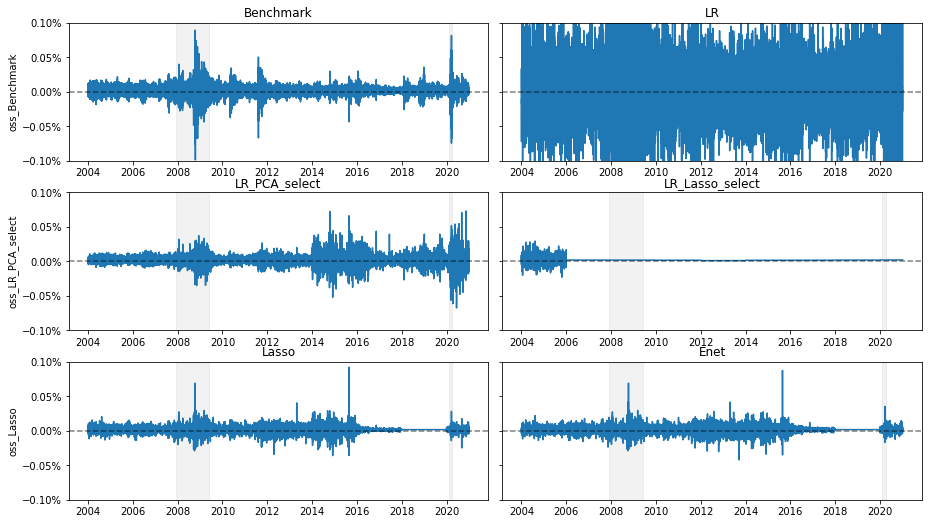

In [154]:
model_list_select = model_list
fig, axs = plt.subplots(
    figsize=(13, 10), nrows=int(len(model_list_select) / 2), ncols=2, sharey=True
)

for i, model_select in tqdm(enumerate(model_list_select)):

    ax = axs.reshape(-1)[i]

    # Plot cumulative returns
    sns.lineplot(
        x='datetime',
        y="oss_" + model_select,
        data=forecast_oss_filter_df.reset_index(),
        lw=1.5,
        ax=ax,
    )

    # Highlight recessions
    ax.axvspan(pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05)
    ax.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05)

    # Mark zero weight
    ax.axhline(0, color="k", ls="--", alpha=0.5)

    # Other settings
    ax.set_title(model_select)
    ax.set_xlabel(None)
    ax.set_ylim(-0.001, 0.001)
    # ax.set_ylabel("Average Turnover")
    # ax.legend(loc="upper left")

# # Fix legend
# handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=12, loc="lower center", ncol=9, bbox_to_anchor=(0.5, 0))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=2))
# for ax in axs.reshape(-1):
#     ax.get_legend().remove()

# Make room for legend
# plt.ylim(-0.15, 1.05)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
fig.savefig(f"../../docs/exhibits/figures/timing_predictions_all_main.pdf")

0it [00:00, ?it/s]

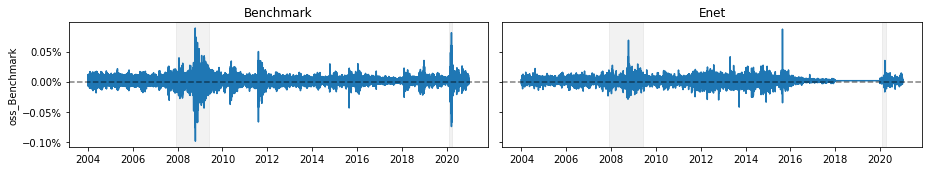

In [148]:
model_list_select = ['Benchmark', 'Enet']
fig, axs = plt.subplots(
    figsize=(13, 3), nrows=int(len(model_list_select) / 2), ncols=2, sharey=True
)

for i, model_select in tqdm(enumerate(model_list_select)):

    ax = axs.reshape(-1)[i]

    # Plot cumulative returns
    sns.lineplot(
        x='datetime',
        y="oss_" + model_select,
        data=forecast_oss_filter_df.reset_index(),
        lw=1.5,
        ax=ax,
    )

    # Highlight recessions
    ax.axvspan(pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05)
    ax.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05)

    # Mark zero weight
    ax.axhline(0, color="k", ls="--", alpha=0.5)

    # Other settings
    ax.set_title(model_select)
    ax.set_xlabel(None)
    # ax.set_ylabel("Average Turnover")
    # ax.legend(loc="upper left")

# # Fix legend
# handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=12, loc="lower center", ncol=9, bbox_to_anchor=(0.5, 0))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=2))
# for ax in axs.reshape(-1):
#     ax.get_legend().remove()

# Make room for legend
# plt.ylim(-0.15, 1.05)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
fig.savefig(f"../../docs/exhibits/figures/timing_predictions_main.pdf")

0it [00:00, ?it/s]

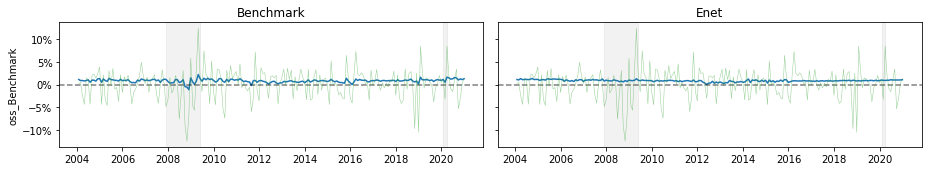

In [149]:
model_list_select = ["Benchmark", "Enet"]
fig, axs = plt.subplots(
    figsize=(13, 3), nrows=int(len(model_list_select) / 2), ncols=2, sharey=True
)

for i, model_select in tqdm(enumerate(model_list_select)):

    ax = axs.reshape(-1)[i]

    # Plot cumulative returns
    sns.lineplot(
        x="datetime",
        y="oss_" + model_select,
        data=forecast_oss_filter_df.groupby(pd.Grouper(freq="1m"))
        .sum()
        .rolling(1)
        .mean()
        .reset_index(),
        lw=1.5,
        ax=ax,
    )

    # Highlight recessions
    ax.axvspan(pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05)
    ax.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05)

    # Mark zero weight
    ax.axhline(0, color="k", ls="--", alpha=0.5)

    # Other settings
    ax.set_title(model_select)
    ax.set_xlabel(None)
    # ax.set_ylabel("Average Turnover")
    # ax.legend(loc="upper left")

    sns.lineplot(
        x="datetime",
        y="ff__mkt",
        data=fret_filter_df.loc[fret_filter_df.index.time != dt.time(9, 30)]
        .groupby(pd.Grouper(freq="1m"))
        .sum()
        .rolling(1)
        .mean()
        .reset_index(),
        lw=0.5,
        color="tab:green",
        alpha=0.5,
        ax=ax,
    )
    ax.set_xlabel(None)


# # Fix legend
# handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=12, loc="lower center", ncol=9, bbox_to_anchor=(0.5, 0))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=0))
# for ax in axs.reshape(-1):
#     ax.get_legend().remove()

# Make room for legend
# plt.ylim(-0.15, 1.05)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
fig.savefig(f"../../docs/exhibits/figures/timing_predictions_agg1m_main.pdf")

0it [00:00, ?it/s]

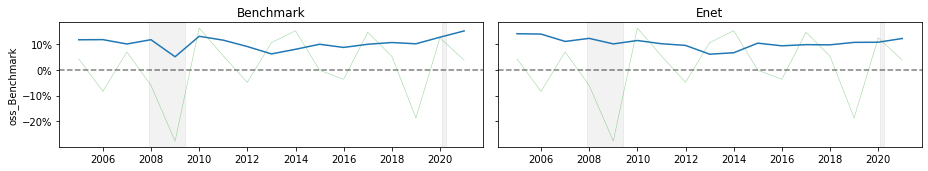

In [150]:
model_list_select = ["Benchmark", "Enet"]
fig, axs = plt.subplots(
    figsize=(13, 3), nrows=int(len(model_list_select) / 2), ncols=2, sharey=True
)

for i, model_select in tqdm(enumerate(model_list_select)):

    ax = axs.reshape(-1)[i]

    # Plot cumulative returns
    sns.lineplot(
        x="datetime",
        y="oss_" + model_select,
        data=forecast_oss_filter_df.groupby(pd.Grouper(freq="1y"))
        .sum()
        .rolling(1)
        .mean()
        .reset_index(),
        lw=1.5,
        ax=ax,
    )

    # Highlight recessions
    ax.axvspan(pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05)
    ax.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05)

    # Mark zero weight
    ax.axhline(0, color="k", ls="--", alpha=0.5)

    # Other settings
    ax.set_title(model_select)
    ax.set_xlabel(None)
    # ax.set_ylabel("Average Turnover")
    # ax.legend(loc="upper left")

    sns.lineplot(
        x="datetime",
        y="ff__mkt",
        data=fret_filter_df.loc[fret_filter_df.index.time != dt.time(9, 30)]
        .groupby(pd.Grouper(freq="1y"))
        .sum()
        .rolling(1)
        .mean()
        .reset_index(),
        lw=0.5,
        color="tab:green",
        alpha=0.5,
        ax=ax,
    )
    ax.set_xlabel(None)


# # Fix legend
# handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=12, loc="lower center", ncol=9, bbox_to_anchor=(0.5, 0))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=0))
# for ax in axs.reshape(-1):
#     ax.get_legend().remove()

# Make room for legend
# plt.ylim(-0.15, 1.05)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
fig.savefig(f"../../docs/exhibits/figures/timing_predictions_agg1y_main.pdf")

In [123]:
(forecast_oss_filter_df.groupby(pd.Grouper(freq="1d"))
        .sum()
        .rolling(1)
        .mean()
        .reset_index()
    )

,datetime,oss_Benchmark,oss_Enet,oss_LR,oss_LR_Lasso_select,oss_LR_PCA_select,oss_Lasso
0,2004-01-02,0.000454,0.000437,0.000786,0.000501,0.000386,0.000430
1,2004-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2004-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2004-01-05,0.000587,0.000506,-0.000392,0.000406,0.000991,0.000508
4,2004-01-06,0.000887,0.000576,0.001070,0.000364,0.000702,0.000575
...,...,...,...,...,...,...,...
6204,2020-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6205,2020-12-28,0.000471,0.000337,-0.004151,0.000476,0.000431,0.000300
6206,2020-12-29,0.000416,0.000482,-0.006313,0.000476,0.000669,0.000482
6207,2020-12-30,0.000426,0.000588,0.003968,0.000476,0.000637,0.000595
